In [92]:
from Data_Prep import handHistoryToRFIdata
import pandas as pd

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn

from matplotlib.pyplot import figure

In [8]:
preflopLines = handHistoryToRFIdata('IPHH/Data.txt')
CardValues = ['A','K','Q','J','T','9','8','7','6','5','4','3','2']
CardValuedict = {'A':12,'K':11,'Q':10,'J':9,'T':8,'9':7,'8':6,'7':5,'6':4,'5':3,'4':2,'3':1,'2':0}

In [35]:
df = preflopLines.copy()
df = df.reset_index() 
position ='UTG+1'
df = df[df['Positions'] == position]

#create card value column
df[['card0','card1']] = pd.DataFrame(df['Hand'].tolist(), index=df.index)  
df['card0_value'] = df['card0'].str[0]
df['card1_value'] = df['card1'].str[0]

#create suited column
df['suited'] = df['card0'].str[1] == df['card1'].str[1]



df.head()




,index,Positions,Hand,card0,card1,card0_value,card1_value,suited
1,0,UTG+1,"(Jh, Ad)",Jh,Ad,J,A,False
7,0,UTG+1,"(Tc, 8c)",Tc,8c,T,8,True
15,0,UTG+1,"(4h, 4s)",4h,4s,4,4,False
26,0,UTG+1,"(Ks, Jc)",Ks,Jc,K,J,False
33,0,UTG+1,"(Ah, Ks)",Ah,Ks,A,K,False


In [84]:

def createPivot(df, suited = False):
    
    #limit field to suited or unsuited
    df = df[df['suited'] == suited]
    
    #reduce to just a Dataframe with the cards 
    reduceddf = df[['card0_value','card1_value']].copy()
    
    #convert to value so these can be sorted
    reduceddf['card0_value'], reduceddf['card1_value'] = reduceddf['card0_value'].map(CardValuedict) , reduceddf['card1_value'].map(CardValuedict)
    
    #sort all small values onto one side so we can make our stair case figure
    #     1 x - -
    #     3 x x x 
    #     2 x x -
    ###     3 2 1
    reduceddf['card0_value'], reduceddf['card1_value'] = reduceddf.min(axis=1), reduceddf.max(axis=1)
    
    #inverse the dictionary 
    inv_CardValuedict = {v: k for k, v in CardValuedict.items()}
    
    #convert back to card value
    reduceddf['card0_value'], reduceddf['card1_value'] = reduceddf['card0_value'].map(inv_CardValuedict) , reduceddf['card1_value'].map(inv_CardValuedict)
    
    reduceddf.reset_index() 
    #set value so that we can count occasions in a pivot
    reduceddf['value'] = 1
    
    #create pivot table
    
    if suited:
        df_piv = reduceddf.pivot_table(index = ['card1_value'], columns = 'card0_value',aggfunc = 'count', values = 'value')
        df_piv = df_piv.reindex(CardValues, columns=CardValues)
    else:
        df_piv = reduceddf.pivot_table(index = ['card0_value'], columns = 'card1_value',aggfunc = 'count', values = 'value').loc[CardValues,CardValues]
    
    return df_piv


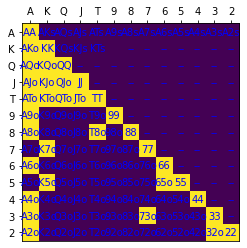

In [109]:

df_piv = createPivot(df, False)


#if left is greater than right then '--'
#else use CardValues[i] + CardValues[j] + 'o'


#for i in range(len(CardValues)):
 #   for j in range(len(CardValues)):
  #      OffSuiteLables = np.array()

OffSuiteLables = np.array([['AA', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--'],
                            ['AKo', 'KK', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--'],
                            ['AQo', 'KQo', 'QQ', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--'],
                            ['AJo', 'KJo', 'QJo', 'JJ', '--', '--', '--', '--', '--', '--', '--', '--', '--'],
                            ['ATo', 'KTo', 'QTo', 'JTo','TT', '--', '--', '--', '--', '--', '--', '--', '--'],
                            ['A9o', 'K9o', 'Q9o', 'J9o', 'T9o', '99', '--', '--', '--', '--', '--', '--', '--'],
                            ['A8o', 'K8o', 'Q8o', 'J8o', 'T8o', '98o', '88', '--', '--', '--', '--', '--', '--'],
                          ['A7o', 'K7o', 'Q7o', 'J7o', 'T7o', '97o', '87o', '77', '--', '--', '--', '--', '--',],
                          ['A6o', 'K6o', 'Q6o', 'J6o', 'T6o', '96o', '86o', '76o', '66', '--', '--', '--', '--'],
                          ['A5o', 'K5o', 'Q5o', 'J5o', 'T5o', '95o', '85o', '75o', '65o', '55', '--', '--', '--'],
                          ['A4o', 'K4o', 'Q4o', 'J4o', 'T4o', '94o', '84o', '74o', '64o', '54o', '44', '--', '--'],
                          ['A3o', 'K3o', 'Q3o', 'J3o', 'T3o', '93o', '83o', '73o', '63o', '53o', '43o', '33', '--'],
                            ['A2o', 'K2o', 'Q2o', 'J2o', 'T2o', '92o', '82o', '72o', '62o', '52o', '42o', '32o', '22']])



OffSuiteLables = np.array([['AA', 'AKs', 'AQs', 'AJs', 'ATs', 'A9s', 'A8s', 'A7s', 'A6s', 'A5s', 'A4s', 'A3s', 'A2s'],
                            ['AKo', 'KK', 'KQs', 'KJs', 'KTs', '', '--', '--', '--', '--', '--', '--', '--'],
                            ['AQo', 'KQo', 'QQ', '--', '--', '--', '--', '--', '--', '--', '--', '--', '--'],
                            ['AJo', 'KJo', 'QJo', 'JJ', '--', '--', '--', '--', '--', '--', '--', '--', '--'],
                            ['ATo', 'KTo', 'QTo', 'JTo','TT', '--', '--', '--', '--', '--', '--', '--', '--'],
                            ['A9o', 'K9o', 'Q9o', 'J9o', 'T9o', '99', '--', '--', '--', '--', '--', '--', '--'],
                            ['A8o', 'K8o', 'Q8o', 'J8o', 'T8o', '98o', '88', '--', '--', '--', '--', '--', '--'],
                          ['A7o', 'K7o', 'Q7o', 'J7o', 'T7o', '97o', '87o', '77', '--', '--', '--', '--', '--',],
                          ['A6o', 'K6o', 'Q6o', 'J6o', 'T6o', '96o', '86o', '76o', '66', '--', '--', '--', '--'],
                          ['A5o', 'K5o', 'Q5o', 'J5o', 'T5o', '95o', '85o', '75o', '65o', '55', '--', '--', '--'],
                          ['A4o', 'K4o', 'Q4o', 'J4o', 'T4o', '94o', '84o', '74o', '64o', '54o', '44', '--', '--'],
                          ['A3o', 'K3o', 'Q3o', 'J3o', 'T3o', '93o', '83o', '73o', '63o', '53o', '43o', '33', '--'],
                            ['A2o', 'K2o', 'Q2o', 'J2o', 'T2o', '92o', '82o', '72o', '62o', '52o', '42o', '32o', '22']])



fig, ax = plt.subplots()
ax.set_xticks(np.arange(len(CardValues)))
ax.set_yticks(np.arange(len(CardValues)))

ax.set_xticklabels(CardValues)
ax.set_yticklabels(CardValues) #set to the poker range convention

ax.xaxis.tick_top() 




ax.imshow(df_piv>1)

for i in range(len(CardValues)):
    for j in range(len(CardValues)):
        text = ax.text(j, i, OffSuiteLables[i, j],
                       ha="center", va="center", color="b")


        
